In [1]:
import torch.nn as nn
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from helperLibrary import (
    hard_decisions,
    StreamManagement,
    MyResourceGrid,
    Mapper,
    MyDemapper,
    MyResourceGridMapper,
    mygenerate_OFDMchannel,
    RemoveNulledSubcarriers,
    MyApplyOFDMChannel,
    MyApplyTimeChannel,
    OFDMModulator,
    OFDMDemodulator,
    BinarySource,
    ebnodb2no,
    complex_normal,
    time_lag_discrete_time_channel,
    cir_to_time_channel,
)

from sionna_tf import (
    MyLMMSEEqualizer,
)
from channel import (
    LSChannelEstimator,
)  # , time_lag_discrete_time_channel #, ApplyTimeChannel #cir_to_time_channel

from Encode_Decode.ldpc import LDPC5GDecoder, LDPC5GEncoder
from NR_Receiver import NeuralReceiver


class Transmitter(nn.Module):
    def __init__(
        self,
        num_rx=1,
        num_tx=1,
        batch_size=1,
        fft_size=76,
        num_ofdm_symbols=14,
        num_bits_per_symbol=4,
        subcarrier_spacing=15e3,
        num_guard_carriers=[15, 16],
        pilot_ofdm_symbol_indices=[2],
        USE_LDPC=True,
        pilot_pattern="kronecker",
        guards=True,
        showfig=True,
    ) -> None:
        self.fft_size = fft_size
        self.batch_size = batch_size
        self.num_bits_per_symbol = num_bits_per_symbol
        self.showfig = showfig
        self.pilot_pattern = pilot_pattern

        # Generate random channel data
        self.channeldataset = RandomChannelDataset(num_rx=num_rx, num_tx=num_tx)

        # Load channel dataset using DataLoader with batch_size=1
        self.data_loader = DataLoader(
            dataset=self.channeldataset,
            batch_size=batch_size,
            shuffle=True,
            pin_memory=True,
        )

        h, tau = next(iter(self.data_loader))  # Get the first batch of random channels
        #         h shape: torch.Size([64, 1, 1, 1, 16, 10, 1])
        # tau shape: torch.Size([64, 1, 1, 10])
        print("h shape:", h.shape)
        print("tau shape:", tau.shape)

        # torch dataloaders
        self.data_loader = DataLoader(
            dataset=self.channeldataset,
            batch_size=batch_size,
            shuffle=True,
            pin_memory=True,
        )
        if showfig:
            self.plotchimpulse()

        # The number of transmitted streams is equal to the number of UT antennas
        # in both uplink and downlink
        # NUM_STREAMS_PER_TX = NUM_UT_ANT
        # NUM_UT_ANT = num_rx
        num_streams_per_tx = num_rx  ##1
        # Create an RX-TX association matrix.
        # RX_TX_ASSOCIATION[i,j]=1 means that receiver i gets at least one stream
        # from transmitter j. Depending on the transmission direction (uplink or downlink),
        # the role of UT and BS can change.
        # For example, considering a system with 2 RX and 4 TX, the RX-TX
        # association matrix could be
        # [ [1 , 1, 0, 0],
        #   [0 , 0, 1, 1] ]
        # which indicates that the RX 0 receives from TX 0 and 1, and RX 1 receives from
        # TX 2 and 3.
        #
        # we have only a single transmitter and receiver,
        # the RX-TX association matrix is simply:
        # RX_TX_ASSOCIATION = np.array([[1]]) #np.ones([num_rx, 1], int)
        RX_TX_ASSOCIATION = np.ones([num_rx, num_tx], int)  # [[1]]
        self.STREAM_MANAGEMENT = StreamManagement(
            RX_TX_ASSOCIATION, num_streams_per_tx
        )  # RX_TX_ASSOCIATION, NUM_STREAMS_PER_TX

        if guards:
            cyclic_prefix_length = 6  # 0 #6 Length of the cyclic prefix
            if num_guard_carriers is None and type(num_guard_carriers) is not list:
                num_guard_carriers = [
                    5,
                    6,
                ]  # [0, 0] #List of two integers defining the number of guardcarriers at the left and right side of the resource grid.
            dc_null = True  # False
            if (
                pilot_ofdm_symbol_indices is None
                and type(pilot_ofdm_symbol_indices) is not list
            ):
                pilot_ofdm_symbol_indices = [2, 11]
        else:
            cyclic_prefix_length = 0  # 0 #6 Length of the cyclic prefix
            num_guard_carriers = [
                0,
                0,
            ]  # List of two integers defining the number of guardcarriers at the left and right side of the resource grid.
            dc_null = False
            pilot_ofdm_symbol_indices = [0, 0]
        # pilot_pattern = "kronecker" #"kronecker", "empty"
        # fft_size = 76
        # num_ofdm_symbols=14
        RESOURCE_GRID = MyResourceGrid(
            num_ofdm_symbols=num_ofdm_symbols,
            fft_size=fft_size,
            subcarrier_spacing=subcarrier_spacing,  # 60e3, #30e3,
            num_tx=num_tx,  # 1
            num_streams_per_tx=num_streams_per_tx,  # 1
            cyclic_prefix_length=cyclic_prefix_length,
            num_guard_carriers=num_guard_carriers,
            dc_null=dc_null,
            pilot_pattern=pilot_pattern,
            pilot_ofdm_symbol_indices=pilot_ofdm_symbol_indices,
        )
        if showfig:
            RESOURCE_GRID.show()  # 14(OFDM symbol)*76(subcarrier) array=1064
            RESOURCE_GRID.pilot_pattern.show()

        if showfig and pilot_pattern == "kronecker":

            plt.figure()
            plt.title("Real Part of the Pilot Sequences")
            for i in range(num_streams_per_tx):
                plt.stem(
                    np.real(RESOURCE_GRID.pilot_pattern.pilots[0, i]),
                    markerfmt="C{}.".format(i),
                    linefmt="C{}-".format(i),
                    label="Stream {}".format(i),
                )
            plt.legend()
        print(
            "Average energy per pilot symbol: {:1.2f}".format(
                np.mean(np.abs(RESOURCE_GRID.pilot_pattern.pilots[0, 0]) ** 2)
            )
        )
        self.num_streams_per_tx = num_streams_per_tx
        self.RESOURCE_GRID = RESOURCE_GRID

        # num_bits_per_symbol = 4
        # Codeword length
        n = int(
            RESOURCE_GRID.num_data_symbols * num_bits_per_symbol
        )  # num_data_symbols:64*14=896 896*4=3584, if empty 1064*4=4256

        # USE_LDPC = True
        if USE_LDPC:
            coderate = 0.5
            # Number of information bits per codeword
            k = int(n * coderate)
            encoder = LDPC5GEncoder(k, n)  # 1824, 3648
            decoder = LDPC5GDecoder(encoder, hard_out=True)
            self.decoder = decoder
            self.encoder = encoder
        else:
            coderate = 1
            # Number of information bits per codeword
            k = int(n * coderate)
        self.k = k  # Number of information bits per codeword
        self.USE_LDPC = USE_LDPC
        self.coderate = coderate

        self.mapper = Mapper("qam", num_bits_per_symbol)
        self.rg_mapper = MyResourceGridMapper(
            RESOURCE_GRID
        )  # ResourceGridMapper(RESOURCE_GRID)

        # receiver part
        self.mydemapper = MyDemapper(
            "app", constellation_type="qam", num_bits_per_symbol=num_bits_per_symbol
        )

    def plotchimpulse(self):
        h_b, tau_b = next(
            iter(self.data_loader)
        )  # h_b: [64, 1, 1, 1, 16, 10, 1], tau_b=[64, 1, 1, 10]
        # print(h_b.shape) #[batch, num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]
        # print(tau_b.shape) #[batch, num_rx, num_tx, num_paths]
        tau_b = tau_b.numpy()  # torch tensor to numpy
        h_b = h_b.numpy()
        plt.figure()
        plt.title("Channel impulse response realization")
        plt.stem(
            tau_b[0, 0, 0, :] / 1e-9, np.abs(h_b)[0, 0, 0, 0, 0, :, 0]
        )  # 10 different pathes
        plt.xlabel(r"$\tau$ [ns]")
        plt.ylabel(r"$|a|$")

    def generateChannel(self, x_rg, no, channeltype="ofdm"):
        # x_rg:[batch_size, num_tx, num_streams_per_tx, num_ofdm_symbols, fft_size][64,1,1,14,76]

        h_b, tau_b = self.get_htau_batch()
        h_out = None
        # print(h_b.shape) #complex (64, 1, 1, 1, 16, 10, 1)[batch, num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]
        # print(tau_b.shape) #float (64, 1, 1, 10)[batch, num_rx, num_tx, num_paths]
        if channeltype == "ofdm":
            # Generate the OFDM channel response
            # computes the Fourier transform of the continuous-time channel impulse response at a set of `frequencies`, corresponding to the different subcarriers.
            ##h: [64, 1, 1, 1, 16, 10, 1], tau: [64, 1, 1, 10] => (64, 1, 1, 1, 16, 1, 76)
            h_freq = mygenerate_OFDMchannel(
                h_b,
                tau_b,
                self.fft_size,
                subcarrier_spacing=60000.0,
                dtype=np.complex64,
                normalize_channel=True,
            )
            print("h_freq.shape", h_freq.shape)
            # h_freq : [batch size, num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, fft_size]
            # (64, 1, 1, 1, 16, 1, 76)

            remove_nulled_scs = RemoveNulledSubcarriers(self.RESOURCE_GRID)
            h_out = remove_nulled_scs(h_freq)  # (64, 1, 1, 1, 16, 1, 64)
            if self.showfig:
                h_freq_plt = h_out[
                    0, 0, 0, 0, 0, 0
                ]  # get the last dimension: fft_size [76]
                # h_freq_plt = h_freq[0,0,0,0,0,0] #get the last dimension: fft_size [76]
                plt.figure()
                plt.plot(np.real(h_freq_plt))
                plt.plot(np.imag(h_freq_plt))
                plt.xlabel("Subcarrier index")
                plt.ylabel("Channel frequency response")
                plt.legend(["Ideal (real part)", "Ideal (imaginary part)"])
                plt.title("Comparison of channel frequency responses")

            # Generate the OFDM channel
            channel_freq = MyApplyOFDMChannel(add_awgn=True)
            # h_freq : [batch size, num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, fft_size]
            # (64, 1, 1, 1, 16, 1, 76)
            y = channel_freq([x_rg, h_freq, no])  # h_freq is array
            # Channel outputs y : [batch size, num_rx, num_rx_ant, num_ofdm_symbols, fft_size], complex
            # print(y.shape) #[64, 1, 1, 14, 76] dim (3,4 removed)

            # y = ApplyOFDMChannel(symbol_resourcegrid=x_rg, channel_frequency=h_freq, noiselevel=no, add_awgn=True)
            # y is the symbol received after the channel and noise
            # Channel outputs y : [batch size, num_rx, num_rx_ant, num_ofdm_symbols, fft_size], complex
        elif channeltype == "perfect":
            y = x_rg
        elif channeltype == "awgn":
            y = x_rg  # (64, 1, 1, 14, 76)
            noise = complex_normal(y.shape, var=1.0)
            print(noise.dtype)
            noise = noise.astype(y.dtype)
            noise *= np.sqrt(no)
            y = y + noise
        elif channeltype == "time":
            bandwidth = self.RESOURCE_GRID.bandwidth  # 4560000
            l_min, l_max = time_lag_discrete_time_channel(bandwidth)  # -6, 20
            l_tot = l_max - l_min + 1  # 27
            # Compute the discrete-time channel impulse reponse
            h_time = cir_to_time_channel(
                bandwidth, h_b, tau_b, l_min=l_min, l_max=l_max, normalize=True
            )
            # h_time: [batch size, num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, l_max - l_min + 1] complex[64, 1, 1, 1, 16, 1, 27]
            h_out = h_time
            if self.showfig:
                plt.figure()
                plt.title("Discrete-time channel impulse response")
                plt.stem(np.abs(h_time[0, 0, 0, 0, 0, 0]))
                plt.xlabel(r"Time step $\ell$")
                plt.ylabel(r"$|\bar{h}|$")
            # channel_time = ApplyTimeChannel(self.RESOURCE_GRID.num_time_samples, l_tot=l_tot, add_awgn=False)
            channel_time = MyApplyTimeChannel(
                self.RESOURCE_GRID.num_time_samples, l_tot=l_tot, add_awgn=True
            )
            # OFDM modulator and demodulator
            modulator = OFDMModulator(self.RESOURCE_GRID.cyclic_prefix_length)
            demodulator = OFDMDemodulator(
                self.RESOURCE_GRID.fft_size,
                l_min,
                self.RESOURCE_GRID.cyclic_prefix_length,
            )

            # OFDM modulation with cyclic prefix insertion
            # x_rg:[batch_size, num_tx, num_streams_per_tx, num_ofdm_symbols, fft_size][64,1,1,14,76]
            x_time = modulator(x_rg)  # output: (64, 1, 1, 1064)
            # Compute the channel output
            # This computes the full convolution between the time-varying
            # discrete-time channel impulse reponse and the discrete-time
            # transmit signal. With this technique, the effects of an
            # insufficiently long cyclic prefix will become visible. This
            # is in contrast to frequency-domain modeling which imposes
            # no inter-symbol interfernce.
            y_time = channel_time([x_time, h_time, no])  # [64, 1, 1, 1174]
            # y_time = channel_time([x_time, h_time]) #(64, 1, 1, 1090) complex

            # Do modulator and demodulator test
            y_test = demodulator(x_time)
            differences = np.abs(x_rg - y_test)
            threshold = 1e-7
            num_differences = np.sum(differences > threshold)
            print("Number of differences:", num_differences)
            print(np.allclose(x_rg, y_test))
            print("Demodulation error (L2 norm):", np.linalg.norm(x_rg - y_test))

            # OFDM demodulation and cyclic prefix removal
            y = demodulator(y_time)
            # y = y_test
            # y: [64, 1, 1, 14, 76]
        return y, h_out

    def get_htau_batch(self, returnformat="numpy"):
        h_b, tau_b = next(
            iter(self.data_loader)
        )  # h_b: [64, 1, 1, 1, 16, 10, 1], tau_b=[64, 1, 1, 10]
        # print(h_b.shape) #[batch, num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]
        # print(tau_b.shape) #[batch, num_rx, num_tx, num_paths]
        if returnformat == "numpy":
            tau_b = tau_b.numpy()  # torch tensor to numpy
            h_b = h_b.numpy()
        return h_b, tau_b

    def __call__(self, b=None, ebno_db=15.0, channeltype="ofdm", perfect_csi=False):
        # Transmitter
        if b is None:
            binary_source = BinarySource()
            # Start Transmitter self.k Number of information bits per codeword
            b = binary_source(
                [self.batch_size, 1, self.num_streams_per_tx, self.k]
            )  # [64,1,1,3584] if empty [64,1,1,1536] [batch_size, num_tx, num_streams_per_tx, num_databits]
        c = self.encoder(b) if self.USE_LDPC else b
        x = self.mapper(
            c
        )  # np.array[64,1,1,896] if empty np.array[64,1,1,1064] 1064*4=4256 [batch_size, num_tx, num_streams_per_tx, num_data_symbols]
        x_rg = self.rg_mapper(x)  ##complex array[64,1,1,14,76] 14*76=1064
        # output: [batch_size, num_tx, num_streams_per_tx, num_ofdm_symbols, fft_size][64,1,1,14,76]

        ebno_db = 15.0
        # no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate, RESOURCE_GRID)
        no = ebnodb2no(ebno_db, self.num_bits_per_symbol, self.coderate)
        # Convert it to a NumPy float
        no = np.float32(no)  # 0.0158

        y, h_out = self.generateChannel(x_rg, no, channeltype=channeltype)
        # y is the symbol received after the channel and noise
        # Channel outputs y : [batch size, num_rx, num_rx_ant, num_ofdm_symbols, fft_size], complex
        y = np.array(y)
        h_out = np.array(h_out)
        print("no:", no)
        return y, h_out, b, no

In [17]:
class BaselineReceiver(nn.Module):
    """Baseline receiver with LS channel estimation and LMMSE equalization."""

    def __init__(self, resource_grid, stream_management, demapper):
        self.resource_grid = resource_grid
        self.stream_management = stream_management
        self.demapper = demapper

    def __call__(self, y, h_out, no, perfect_csi=False):
        if perfect_csi:
            h_hat, err_var = h_out, 0.0
        else:
            ls_est = LSChannelEstimator(
                self.resource_grid, interpolation_type="lin_time_avg"
            )
            y = np.array(y)
            no = np.array(no)
            print("y shape:", y.shape, "ytype:", type(y))
            print("no shape:", no.shape, "notype:", type(no))
            h_hat, err_var = ls_est([y, no])

        lmmse_equ = MyLMMSEEqualizer(self.resource_grid, self.stream_management)
        x_hat, no_eff = lmmse_equ([y, h_hat, err_var, no])
        x_hat = x_hat.numpy()  # (64, 1, 1, 912)
        no_eff = no_eff.numpy()  # (64, 1, 1, 912)
        no_eff = np.mean(no_eff)

        llr_est = self.demapper([x_hat, no_eff])
        # llr_est #(64, 1, 1, 4256)

        b_hat = hard_decisions(llr_est, np.int32)
        # BER = calculate_BER(b, b_hat)
        # print("BER Value:", BER)
        return b_hat

In [7]:
class NeuralReceiver(nn.Module):

    def __init__(
        self,
        resource_grid,
        stream_management,
        num_bits_per_symbol=4,
        num_rx_ant=1,  # Number of antennas per receiver
        num_tx=1,  # Number of receive antennas.
    ):
        super(NeuralReceiver, self).__init__()
        self.resource_grid = resource_grid
        self.stream_management = stream_management
        self.num_bits_per_symbol = num_bits_per_symbol
        self.num_rx_ant = num_rx_ant
        self.num_tx = num_tx

        # Define the channel estimator and equalizer
        # Used convolutional neural network (CNN) for channel estimation and equalization
        # spatial feature extraction
        # The number of input channels is set to 2 * num_rx_ant, which means for each receive antenna (num_rx_ant), you have two input channels: one for the real part and one for the imaginary part of the received signal.

        self.channel_estimator = nn.Sequential(
            nn.Conv2d(
                in_channels=2 * num_rx_ant, out_channels=64, kernel_size=3, padding=1
            ),
            nn.ReLU(),
        )
        self.equalizer = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=2, kernel_size=3, padding=1),
        )
        # The demapper is a simple feedforward neural network
        self.demapper = nn.Sequential(
            nn.Linear(in_features=2, out_features=num_bits_per_symbol),
        )

        # Create the data mask to exclude pilots, guard bands, and DC null
        num_ofdm_symbols = (
            resource_grid.num_ofdm_symbols
        )  # The number of OFDM symbols in the signal.
        fft_size = (
            resource_grid.fft_size
        )  # The size of the FFT used in the OFDM modulation.
        data_mask = np.ones((num_ofdm_symbols, fft_size), dtype=bool)

        # Set guard subcarriers to False
        left_guard = resource_grid.num_guard_carriers[0]
        right_guard = resource_grid.num_guard_carriers[1]
        data_mask[:, :left_guard] = False
        data_mask[:, -right_guard:] = False

        # Set DC null to False
        if resource_grid.dc_null:
            data_mask[:, fft_size // 2] = False

        # Set pilot positions to False
        pilot_pattern = resource_grid.pilot_pattern
        pilot_ofdm_symbol_indices = pilot_pattern.pilot_ofdm_symbol_indices

        # Assume pilot subcarriers span all frequencies for the specified OFDM symbols
        for symbol_idx in pilot_ofdm_symbol_indices:
            data_mask[symbol_idx, :] = (
                False  # Assume entire OFDM symbol is reserved for pilots
            )

        # Flatten data_mask to 1D for easy indexing later
        self.data_mask_flat = data_mask.flatten()

    def forward(self, y, no):
        # y: [batch_size, num_rx, num_rx_ant, num_ofdm_symbols, fft_size], complex
        if not torch.is_tensor(y):
            y = torch.from_numpy(y)
        y = y.type(torch.complex64)
        print("Shape of y:", y.shape)

        batch_size, num_rx, num_rx_ant, num_ofdm_symbols, fft_size = y.shape

        # Combine real and imaginary parts into channels
        y_real = y.real.type(torch.float32)
        y_imag = y.imag.type(torch.float32)
        y_input = torch.cat(
            [y_real, y_imag], dim=2
        )  # Shape: [batch_size, num_rx, num_rx_ant*2, num_ofdm_symbols, fft_size]
        # print("Shape of y_input after concatenation:", y_input.shape)

        y_input = y_input.view(batch_size, -1, num_ofdm_symbols, fft_size)
        # print("Shape of y_input after reshaping:", y_input.shape)

        # Pass through the channel estimator
        h_hat = self.channel_estimator(y_input)
        # print("Shape of h_hat after channel estimator:", h_hat.shape)

        # Pass through the equalizer
        x_hat = self.equalizer(h_hat)
        # print("Shape of x_hat after equalizer:", x_hat.shape)

        # Reshape for demapping
        x_hat = x_hat.permute(0, 2, 3, 1).contiguous()
        # print("Shape of x_hat after permute:", x_hat.shape)
        x_hat = x_hat.view(batch_size, -1, 2)
        # print("Shape of x_hat after reshaping for demapper:", x_hat.shape)

        # Apply data mask to select only data subcarriers
        data_mask = torch.from_numpy(self.data_mask_flat).to(x_hat.device)
        x_hat_data = x_hat[:, data_mask, :]  # Only keep data subcarriers
        # print("Shape of x_hat_data after masking:", x_hat_data.shape)

        # Pass through the demapper
        llr_est = self.demapper(x_hat_data)
        # print("Shape of llr_est after demapper:", llr_est.shape)

        # Reshape to match the expected output
        llr_est = llr_est.view(batch_size, 1, 1, -1)
        # print("Shape of llr_est after final reshaping:", llr_est.shape)

        # Convert llr_est to numpy for hard_decisions
        llr_est_np = llr_est.detach().cpu().numpy()
        # print("Shape of llr_est_np:", llr_est_np.shape)
        # hard decision method is used to map the received LLR values into final bit values
        b_hat = hard_decisions(llr_est_np, np.int32)
        # print("Shape of b_hat:", b_hat.shape)

        return b_hat

In [18]:
class RandomChannelDataset(Dataset):
    """Generates random channel data for the transmitter with specified dimensions."""

    def __init__(self, num_rx, num_tx):
        self.num_rx = num_rx
        self.num_tx = num_tx

    def __len__(self):
        return 1000  # Arbitrary length for the dataset

    def __getitem__(self, idx):
        # Generate random complex gains `h` with shape (1, 1, 1, 16, 10, 1)
        h = np.random.randn(1, 1, 1, 16, 10, 1) + 1j * np.random.randn(
            1, 1, 1, 16, 10, 1
        )

        # Generate random delays `tau` with shape (1, 1, 10)
        tau = np.random.rand(1, 1, 10)

        return h, tau

In [19]:
def calculate_BER(bits, bits_est):
    errors = (bits != bits_est).sum()
    N = len(bits.flatten())
    BER = 1.0 * errors / N

    return BER

h shape: torch.Size([64, 1, 1, 1, 16, 10, 1])
tau shape: torch.Size([64, 1, 1, 10])
Average energy per pilot symbol: 1.00
h_freq.shape (64, 1, 1, 1, 16, 1, 76)
sc_ind shape: (44,)
no: 0.007905694
y shape: (64, 1, 1, 14, 76) ytype: <class 'numpy.ndarray'>
no shape: () notype: <class 'numpy.ndarray'>
Baseline Receiver output Parameters:
b: [[[[0. 0. 0. ... 1. 1. 0.]]]


 [[[0. 1. 1. ... 1. 0. 0.]]]


 [[[1. 0. 0. ... 0. 0. 1.]]]


 ...


 [[[0. 1. 0. ... 0. 0. 1.]]]


 [[[0. 0. 1. ... 1. 1. 1.]]]


 [[[0. 1. 0. ... 1. 0. 0.]]]]
b_hat: [[[[0 0 0 ... 1 1 0]]]


 [[[0 1 1 ... 1 0 0]]]


 [[[1 0 0 ... 0 0 1]]]


 ...


 [[[0 1 0 ... 0 0 1]]]


 [[[0 0 1 ... 1 1 1]]]


 [[[0 1 0 ... 1 0 0]]]]
BER: 0.001918979458041958
Shape of y: torch.Size([64, 1, 1, 14, 76])
neural_receiver output:
b (64, 1, 1, 2288)
Estimated Bits (b_hat): (64, 1, 1, 2288)
Bit Error Rate (BER): 0.5007990056818182
Transmitter and Receiver test passed!


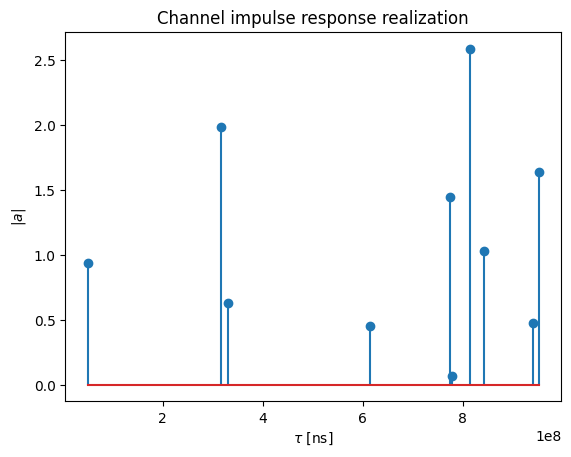

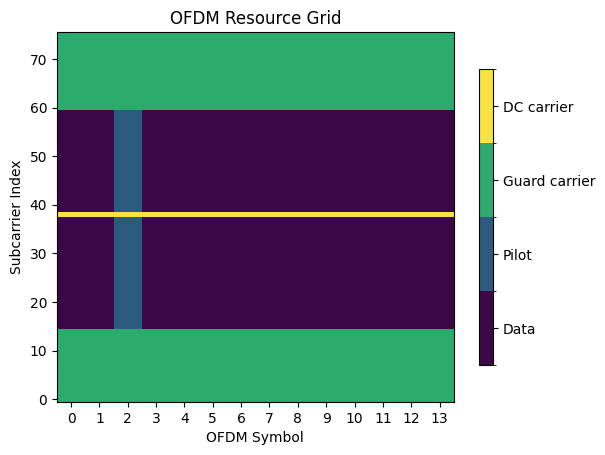

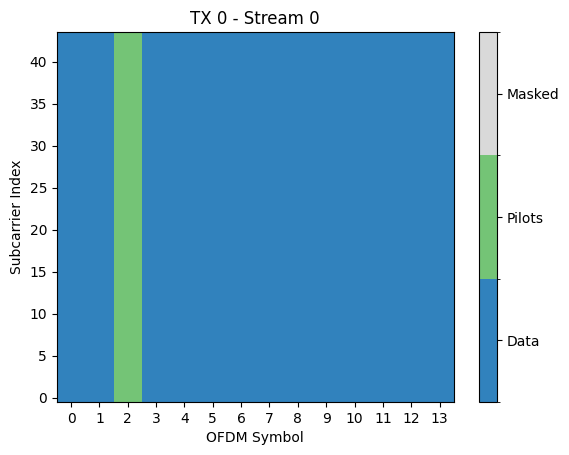

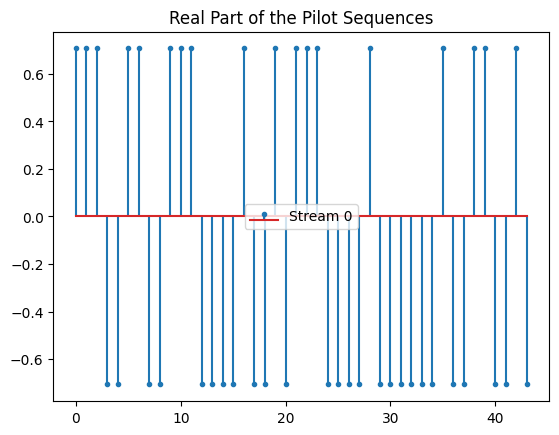

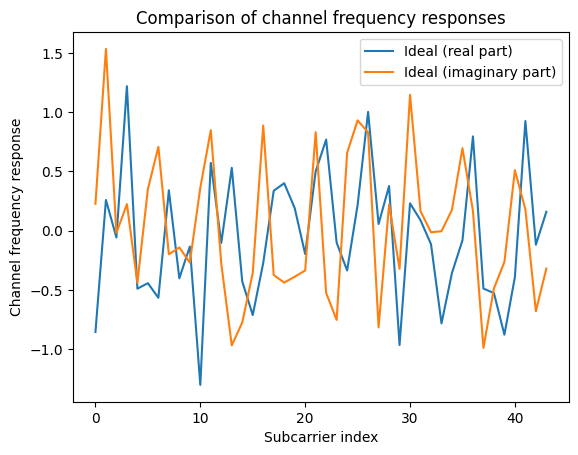

In [20]:
if __name__ == "__main__":
  
    showfigure = True

    transmit = Transmitter(
        num_rx=1,
        num_tx=1,
        batch_size=64,
        fft_size=76,
        num_ofdm_symbols=14,
        num_bits_per_symbol=4,
        subcarrier_spacing=60e3,
        USE_LDPC=False,
        pilot_pattern="kronecker",
        guards=True,
        showfig=showfigure,
    )  # "kronecker" "empty"
    # Receiver
    baseline_receiver = BaselineReceiver(
        resource_grid=transmit.RESOURCE_GRID,
        stream_management=transmit.STREAM_MANAGEMENT,
        demapper=transmit.mydemapper,
    )
    # channeltype="perfect", "awgn", "ofdm", "time"
    y, h_out, b, no = transmit(ebno_db=5.0, channeltype="ofdm", perfect_csi=False)
    # Receive signal
    b_hat1= baseline_receiver(y, h_out, no)
    berr1 = calculate_BER(b, b_hat1)

    # Print baseline receiver evaluation parameters
    print("Baseline Receiver output Parameters:")

    print("b:", b)
    print("b_hat:", b_hat1)
    print("BER:", berr1)

    # Instantiate the neural receiver
    neural_receiver = NeuralReceiver(
        resource_grid=transmit.RESOURCE_GRID,
        stream_management=transmit.STREAM_MANAGEMENT,
        num_bits_per_symbol=transmit.num_bits_per_symbol,
        num_rx_ant=1,
        num_tx=1,
    )

    # Neural Receiver processing
    b_hat2 = neural_receiver(y, no)
    print("neural_receiver output:")
    # Calculate BER
    print("b", b.shape)

    print("Estimated Bits (b_hat):", b_hat2.shape)
    berr2 = calculate_BER(b, b_hat2)
    print("Bit Error Rate (BER):", berr2)
    print("Transmitter and Receiver test passed!")

In [21]:
def plot_ber_comparison(snr_values, ber_baseline, ber_neural):
    plt.figure(figsize=(10, 6))
    plt.plot(snr_values, ber_baseline, label="Baseline Receiver", marker="o")
    plt.plot(snr_values, ber_neural, label="Neural Receiver", marker="x")
    plt.xlabel("SNR [dB]")
    plt.ylabel("BER")
    plt.title("BER Comparison")
    plt.yscale("log")
    plt.legend()
    plt.grid(True)
    plt.show()

h_freq.shape (64, 1, 1, 1, 16, 1, 76)
sc_ind shape: (44,)
no: 0.007905694
y shape: (64, 1, 1, 14, 76) ytype: <class 'numpy.ndarray'>
no shape: () notype: <class 'numpy.ndarray'>
Shape of y: torch.Size([64, 1, 1, 14, 76])
h_freq.shape (64, 1, 1, 1, 16, 1, 76)
sc_ind shape: (44,)
no: 0.007905694
y shape: (64, 1, 1, 14, 76) ytype: <class 'numpy.ndarray'>
no shape: () notype: <class 'numpy.ndarray'>
Shape of y: torch.Size([64, 1, 1, 14, 76])
h_freq.shape (64, 1, 1, 1, 16, 1, 76)
sc_ind shape: (44,)
no: 0.007905694
y shape: (64, 1, 1, 14, 76) ytype: <class 'numpy.ndarray'>
no shape: () notype: <class 'numpy.ndarray'>
Shape of y: torch.Size([64, 1, 1, 14, 76])
h_freq.shape (64, 1, 1, 1, 16, 1, 76)
sc_ind shape: (44,)
no: 0.007905694
y shape: (64, 1, 1, 14, 76) ytype: <class 'numpy.ndarray'>
no shape: () notype: <class 'numpy.ndarray'>
Shape of y: torch.Size([64, 1, 1, 14, 76])
h_freq.shape (64, 1, 1, 1, 16, 1, 76)
sc_ind shape: (44,)
no: 0.007905694
y shape: (64, 1, 1, 14, 76) ytype: <class 

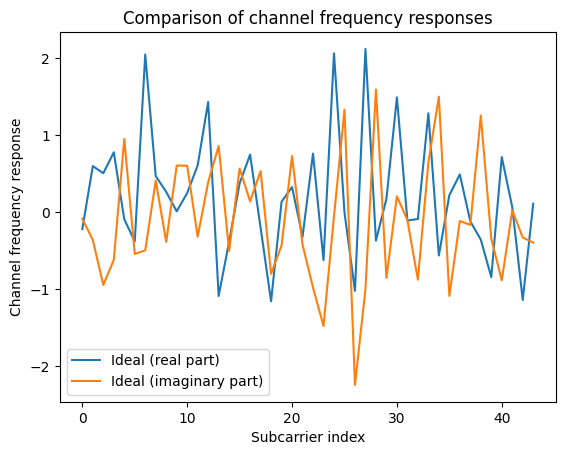

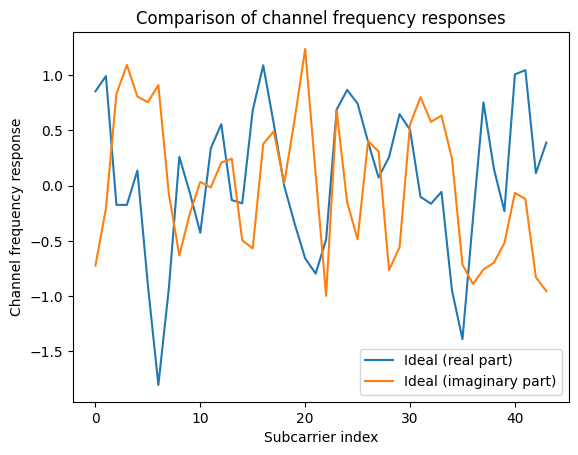

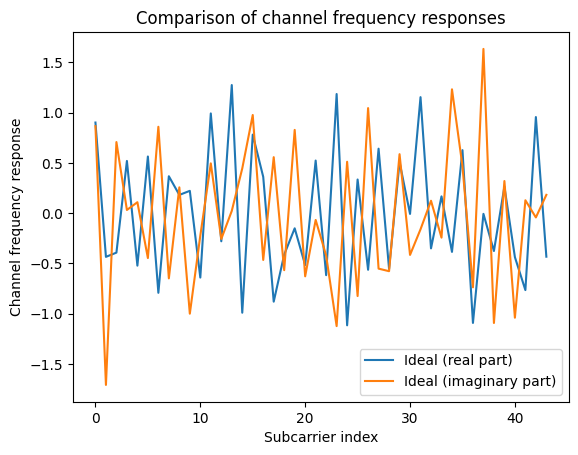

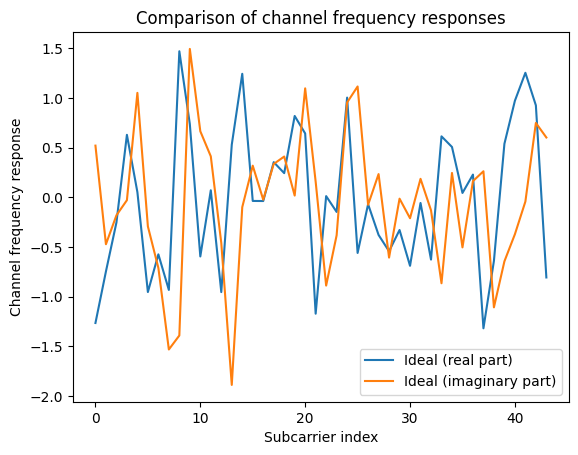

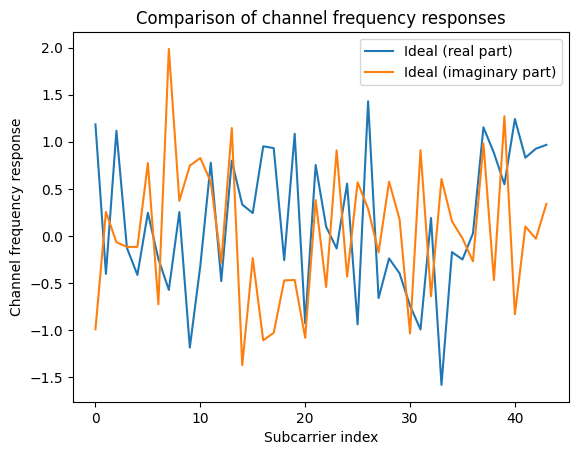

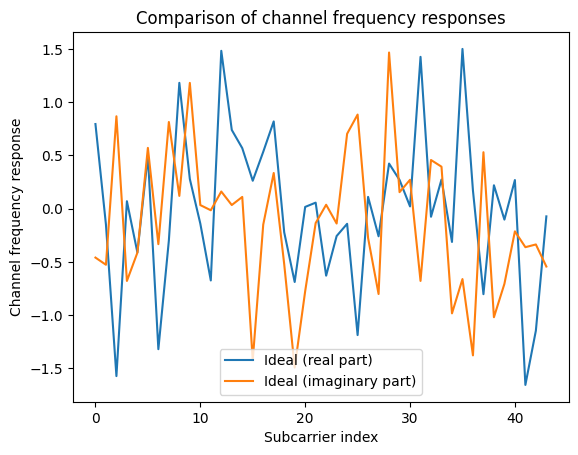

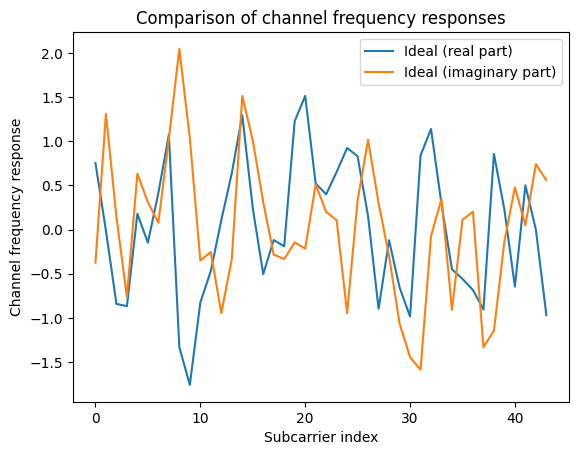

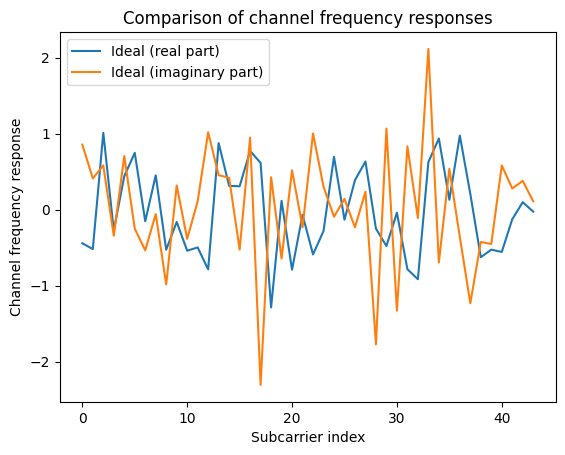

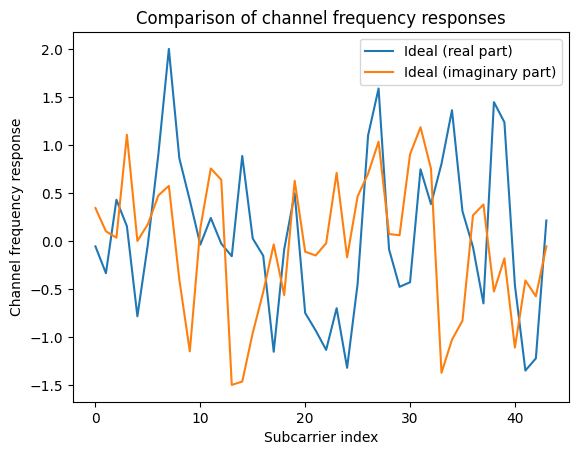

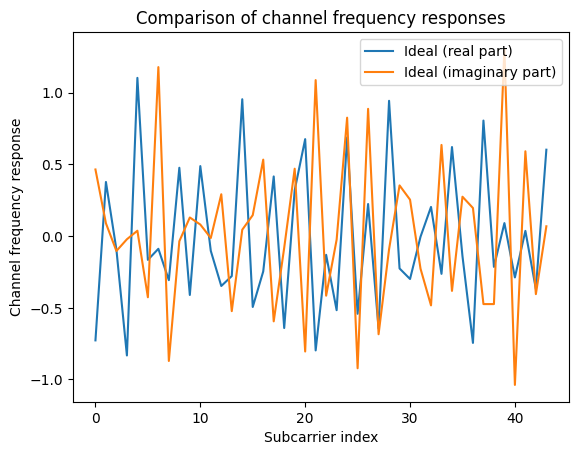

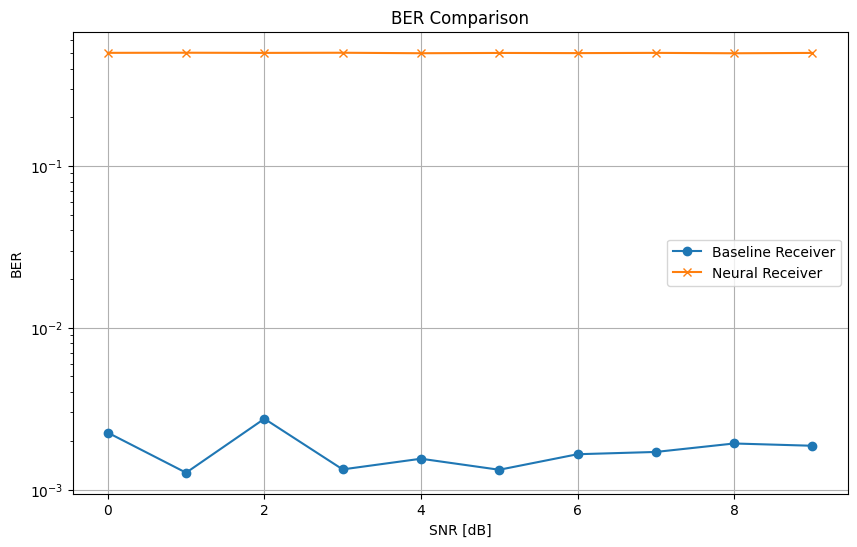

In [23]:
# SNR range for evaluation
snr_range = np.arange(0, 10, 1)
    
ber_baseline_list = []
ber_neural_list = []

for snr in snr_range:
  y, h_out, b, no = transmit(ebno_db=snr, channeltype="ofdm", perfect_csi=False)

        # Baseline Receiver
  b_hat1 = baseline_receiver(y, h_out, no)
  berr1 = calculate_BER(b, b_hat1)
  ber_baseline_list.append(berr1)
    # Neural Receiver
  b_hat2 = neural_receiver(y, no)
  berr2 = calculate_BER(b, b_hat2)
  ber_neural_list.append(berr2)

# Plot BER comparison
plot_ber_comparison(snr_range, ber_baseline_list, ber_neural_list)  